(working-with-rag)=

# Working with RAG in MLRun

## Overview of RAG application and strategy
Retrieval Augmented Generation (RAG) is a common strategy for extending the knowledge of pre-trained LLMs. It gives the LLM a corpus of knowledge to draw from when answering questions about topics or information that were not in the original training set.

### Steps in RAG
1. **Ingest and Index**: Data is split into chunks and indexed into a vector store using an embeddings model.
2. **Retrieve Relevant Data**:The input query from the user is then used to search for relevent chunks of data using semantic similarity search (for example, which chunks are most similar to the desired question or topic). Additionally, the input query to the vector store can be revised, modified, or enhanced, using additional context to ensure that the returned chunks are more relevant.
3. **Format Prompt**:The returned chunks of data from the vector store are formatted and inserted into the prompt for the LLM.
4. **Model Inference**:The LLM is invoked with the user's question, relevant chunks of data, and additional information such as conversation history.

![](_static/rag_architecture.jpg)

### Most important parts of RAG architecture

There are a number of open source and proprietary embeddings models, LLMs, and vector stores.


- **Vector Store**: Used to store the embedded documents in a format that allows for semantic search and retrieval.
    - This demo uses [Milvus](https://milvus.io) &mdash; an open-source vector database designed specifically for similarity search on massive datasets of high-dimensional vectors.
- **Embeddings Model**: Used to embed the documents as well as embedding new user queries for semantic search.
    - The [Hugging Face Massive Text Embedding Benchmark (MTEB) Leaderboard](https://huggingface.co/spaces/mteb/leaderboard) is a great place to start when considering an open source embeddings model.
    - This demo uses either OpenAI's [text-embedding-3-small](https://platform.openai.com/docs/guides/embeddings) or Hugging Face's [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2).
- **LLM**: used for generating responses.
    - The [Hugging Face Open LLM Leaderboard](https://huggingface.co/spaces/open-llm-leaderboard/open_llm_leaderboard) is a great place to start when considering an open source LLM.
    - This demo uses either OpenAI's [gpt-3.5-turbo-0125](https://platform.openai.com/docs/models/gpt-3-5-turbo) or Ollama's [Llama3](https://ollama.com/library/llama3). Additional examples using [Hugging Face](https://huggingface.co) models will be coming in the future.
    
## Prerequisite

In [25]:
# %pip install langchain langchain_community langchain_openai pymilvus langchain_huggingface "protobuf<3.20"

## Install a vector DB and dependencies

As mentioned above, this demo uses [Milvus](https://milvus.io) -&mdash; an open-source vector database designed specifically for similarity search on massive datasets of high-dimensional vectors. It can be installed via [docker-compose](https://milvus.io/docs/v2.0.x/install_standalone-docker.md) or [Kubernetes](https://milvus.io/docs/v2.0.x/install_standalone-helm.md) depending on your MLRun installation method.

This is a simple excerpt to install Milvus standalone via [Helm](https://helm.sh) without persistence &mdash; this is **NOT** for production usage:
```
helm repo add milvus https://milvus-io.github.io/milvus-helm/
helm repo update
helm install milvus milvus/milvus \
    --set cluster.enabled=false \
    --set etcd.replicaCount=1 \
    --set minio.mode=standalone \
    --set minio.persistence.enabled=false \
    --set etcd.persistence.enabled=false \
    --set pulsar.enabled=false \
    --set standalone.persistence.enabled=false
```

Additionally, if you are using Ollama, it can be installed on your [local machine](https://ollama.com/download) or [Kubernetes](https://github.com/otwld/ollama-helm) depending on your MLRun installation method.

This is a simple example to install Ollama via [Helm](https://helm.sh):
```
helm repo add ollama-helm https://otwld.github.io/ollama-helm/
helm repo update
helm install ollama ollama-helm/ollama --set ollama.models={llama3}
```

## Setup

In [62]:
import os

import mlrun
from langchain.vectorstores import Milvus
from langchain_community.chat_models import ChatOllama
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.prompts import PromptTemplate
from langchain_text_splitters import RecursiveCharacterTextSplitter
import pandas as pd
from mlrun.utils import create_class

# OpenAI
OPENAI_API_KEY = ""
OPENAI_BASE_URL = "https://api.openai.com/v1"
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["OPENAI_BASE_URL"] = OPENAI_BASE_URL
OPENAI_MODEL = "gpt-3.5-turbo-0125"

# Ollama
OLLAMA_URL = "http://ollama.default.svc.cluster.local:11434"
OLLAMA_MODEL = "llama3"

# Embeddings
EMBEDDINGS_MODEL = "all-MiniLM-L6-v2"

# Milvus
MILVUS_CONNECTION_ARGS = {
    "host": "milvus.default.svc.cluster.local",
    "port": "19530",
}

PROMPT_TEMPLATE = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""

## Select OpenAI or Ollama

In [12]:
MODE = "ollama"  # also supports ollama

if MODE == "openai":
    embeddings_class = "langchain_openai.embeddings.OpenAIEmbeddings"
    embeddings_kwargs = {"model": "text-embedding-3-small"}
    llm_class = "langchain_openai.chat_models.ChatOpenAI"
    llm_kwargs = {"model": OPENAI_MODEL}

elif MODE == "ollama":
    embeddings_class = "langchain_huggingface.embeddings.HuggingFaceEmbeddings"
    embeddings_kwargs = {"model_name": EMBEDDINGS_MODEL}
    llm_class = "langchain_community.chat_models.ChatOllama"
    llm_kwargs = {"model": OLLAMA_MODEL, "base_url": OLLAMA_URL}

else:
    raise ValueError(f"Mode {MODE} not supported")

print(f"Using mode: {MODE.upper()}\n")
print(f"Embeddings model: {embeddings_class}\n")
print(f"LLM model: {llm_class}")

Using mode: OLLAMA

Embeddings model: langchain_huggingface.embeddings.HuggingFaceEmbeddings

LLM model: langchain_community.chat_models.ChatOllama


## Create a data indexing function

In [13]:
%%writefile index_data.py
import mlrun
from mlrun.utils import create_class
import pandas as pd
from langchain_community.vectorstores import Milvus
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

def get_existing_milvus_documents(store: Milvus) -> set:
    if store.col:
        resp = store.col.query(expr="pk >= 0", output_fields=["source"])
        return {s["source"] for s in resp}
    else:
        return set()

@mlrun.handler()
def index_urls(
    data: pd.DataFrame,
    url_column: str,
    embeddings_class: str,
    embeddings_kwargs: dict,
    milvus_host: str,
    milvus_port: int,
    chunk_size: int,
    chunk_overlap: int,
):  
    # Load embeddings and LLM models
    embeddings = create_class(embeddings_class)(**embeddings_kwargs)
    
    # Load vector store
    vector_db = Milvus(
        embedding_function=embeddings,
        connection_args={
            "host": milvus_host,
            "port": str(milvus_port),
        },
        auto_id=True
    )
    
    # Get input URLs
    urls = set(data[url_column].values)
    
    # Filter out documents already ingested
    new_urls = urls - get_existing_milvus_documents(vector_db)
    
    # Index new documents into the vector store
    if len(new_urls) > 0:
        
        # Scrape webpage
        loader = WebBaseLoader(web_paths=new_urls)
        docs = loader.load()

        # Split documents
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap
        )
        splits = text_splitter.split_documents(docs)
        
        # Index in Milvus
        ids = vector_db.add_documents(splits)
        
        print(f"Indexed {len(new_urls)} new documents")
    
    else:
        print("No new documents to index")

Overwriting index_data.py


## Index the dataset in the vector store

In [14]:
project = mlrun.get_or_create_project("rag")

> 2024-06-11 17:43:38,363 [info] Project loaded successfully: {'project_name': 'rag'}


In [15]:
index_fn = project.set_function(
    name="index",
    func="index_data.py",
    kind="job",
    image="mlrun/mlrun",
    handler="index_urls",
)

# Only relevant for OpenAI
index_fn.set_envs(
    {"OPENAI_API_KEY": OPENAI_API_KEY, "OPENAI_BASE_URL": OPENAI_BASE_URL}
)

In [16]:
data = pd.DataFrame(
    [
        {"url": "https://docs.mlrun.org/en/latest/index.html"},
        {"url": "https://docs.mlrun.org/en/latest/cheat-sheet.html"},
        {"url": "https://docs.mlrun.org/en/latest/tutorials/01-mlrun-basics.html"},
    ]
)
data

,url
0,https://docs.mlrun.org/en/latest/index.html
1,https://docs.mlrun.org/en/latest/cheat-sheet.html
2,https://docs.mlrun.org/en/latest/tutorials/01-...


In [7]:
dataset_artifact = project.log_dataset(key="to-index", df=data)
dataset_artifact.uri

'store://datasets/rag/to-index#0@d4cdbf83-887c-42f6-abdd-8518c32f0f65'

In [8]:
project.run_function(
    index_fn,
    inputs={"data": dataset_artifact.uri},
    params={
        "url_column": "url",
        "embeddings_class": embeddings_class,
        "embeddings_kwargs": embeddings_kwargs,
        "milvus_host": MILVUS_HOST,
        "milvus_port": MILVUS_PORT,
        "chunk_size": 2000,
        "chunk_overlap": 200,
    },
    local=True,
)

> 2024-06-11 16:52:18,178 [info] Storing function: {'name': 'index-index-urls', 'uid': 'f5ad96d933954991ad96d3cf2aa30067', 'db': 'http://mlrun-api:8080'}


`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
The class `Milvus` was deprecated in LangChain 0.2.0 and will be removed in 0.3.0. An updated version of the class exists in the langchain-milvus package and should be used instead. To use it run `pip install -U langchain-milvus` and import as `from langchain_milvus import MilvusVectorStore`.


Indexed 3 new documents


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
rag,...2aa30067,0,Jun 11 16:52:18,completed,index-index-urls,v3io_user=nickkind=localowner=nickhost=jupyter-nick-9dccd9cf6-kp69z,data,url_column=urlembeddings_class=langchain_huggingface.embeddings.HuggingFaceEmbeddingsembeddings_kwargs={'model_name': 'all-MiniLM-L6-v2'}milvus_host=milvus.default.svc.cluster.localmilvus_port=19530chunk_size=2000chunk_overlap=200,,


> 2024-06-11 16:52:39,318 [info] Run execution finished: {'status': 'completed', 'name': 'index-index-urls'}


## Create a retrieval function

In [147]:
%%writefile retrieval.py
import mlrun
from mlrun.serving.v2_serving import V2ModelServer
from typing import Dict, Any, Union
from langchain_core.language_models.llms import LLM
import langchain_community.llms
from mlrun.utils import create_class
from langchain_community.vectorstores import Milvus

class QueryMilvus:
    def __init__(
        self,
        embeddings_class: str,
        embeddings_kwargs: dict,
        milvus_connection_args: dict,
        num_documents: int = 3
    ):
        self.embeddings_class = embeddings_class
        self.embeddings_kwargs = embeddings_kwargs
        self.embeddings = create_class(self.embeddings_class)(**self.embeddings_kwargs)
        self.milvus_connection_args = milvus_connection_args
        self.vector_db = Milvus(
            embedding_function=self.embeddings,
            connection_args=self.milvus_connection_args,
            auto_id=True
        )
        self.num_documents = num_documents
        
    def do(self, event: dict):
        question = event["question"]
        num_documents = event.get("num_documents", self.num_documents)
        docs = self.vector_db.similarity_search(question, k=num_documents)
        event["context"] = "\n\n".join(doc.page_content for doc in docs)
        event["sources"] = list({doc.metadata["source"] for doc in docs})
        return event

    
class FormatPrompt:
    def __init__(self, prompt: str):
        self.prompt = prompt
        
    def do(self, event:dict):
        formatted_prompt = self.prompt.format(**event)
        event["inputs"] = [formatted_prompt]
        return event
    
        
class LangChainModelServer(mlrun.serving.V2ModelServer):
    def __init__(
        self,
        context: mlrun.MLClientCtx = None,
        model_class: str = None,
        llm: Union[str, LLM] = None,
        init_kwargs: Dict[str, Any] = None,
        generation_kwargs: Dict[str, Any] = None,
        name: str = None,
        model_path: str = None,
        **kwargs,
    ):
        """
        Initialize a serving class for general llm usage.
        :param model_class:      The class of the model to use.
        :param llm:              The name of specific llm to use, or the llm object itself in case of local usage.
        :param init_kwargs:      The initialization arguments to use while initializing the llm.
        :param generation_kwargs: The generation arguments to use while generating text.
        """
        super().__init__(
            name=name,
            context=context,
            model_path=model_path
        )
        self.model_class = model_class
        self.llm = llm
        self.init_kwargs = init_kwargs or {}
        self.generation_kwargs = generation_kwargs

    def load(self):
        # If the llm is already an LLM object, use it directly
        if isinstance(self.llm, LLM):
            self.model = self.llm
            return
        # If the llm is a string (or not given, then we take default model), load the llm from langchain.
        self.model = create_class(self.model_class)(**self.init_kwargs)

    def predict(self, request: Dict[str, Any], generation_kwargs: Dict[str, Any] = None):
        inputs = request.get("inputs", [])
        generation_kwargs = generation_kwargs or self.generation_kwargs
        return self.model.invoke(input=inputs[0], config=generation_kwargs).dict()

Overwriting retrieval.py


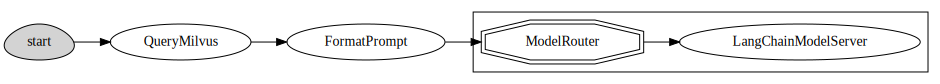

In [148]:
rag_fn = project.set_function(
    name="rag",
    func="retrieval.py",
    kind="serving",
    image="mlrun/mlrun",
    requirements=[
        "langchain",
        "langchain_community",
        "langchain_openai",
        "pymilvus",
        "langchain_huggingface",
    ],
)

graph = rag_fn.set_topology("flow", engine="async")

graph.add_step(
    class_name="QueryMilvus",
    embeddings_class=embeddings_class,
    embeddings_kwargs=embeddings_kwargs,
    milvus_connection_args=MILVUS_CONNECTION_ARGS,
)
graph.add_step(class_name="FormatPrompt", prompt=PROMPT_TEMPLATE, after="$prev")

router = graph.add_step(
    "*mlrun.serving.ModelRouter",
    name="ModelRouter",
    after="$prev",
    result_path="prediction",
).respond()
router.add_route(
    key="LangChainModelServer",
    class_name="LangChainModelServer",
    model_class=llm_class,
    init_kwargs=llm_kwargs,
    result_path="output",
    after="$prev",
)
graph.plot(rankdir="LR")

## Test locally

In [140]:
%%time
mock = rag_fn.to_mock_server()
resp = mock.test(
    path="/",
    body={"question": "Give me a python example of how to deploy a serving function"},
)

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.


> 2024-06-11 18:54:01,813 [info] model LangChainModelServer was loaded
> 2024-06-11 18:54:01,814 [info] Loaded ['LangChainModelServer']
CPU times: user 300 ms, sys: 78.5 ms, total: 379 ms
Wall time: 18.5 s


In [141]:
print(resp["prediction"]["outputs"]["content"])

Here is an example of deploying a serving function in Python:

```
serving_fn = project.set_function(
    func="",
    name="my-serving",
    image="mlrun/mlrun",
    kind="serving",
    requirements=["scikit-learn~=1.4.0"],
)

# Add models
serving_fn.add_model(
    "cancer-classifier",
    model_path=trainer_run.outputs["model"],
    class_name="mlrun.frameworks.sklearn.SklearnModelServer",
)

project.deploy_function(serving_fn)
```

Thanks for asking!


In [142]:
print(resp["question"])

Give me a python example of how to deploy a serving function


In [143]:
print(resp["sources"])

{'https://docs.mlrun.org/en/latest/cheat-sheet.html', 'https://docs.mlrun.org/en/latest/tutorials/01-mlrun-basics.html'}


In [144]:
# Formatted prompt - long output
# print(resp["inputs"][0])

## Deploy to an endpoint

In [149]:
project.deploy_function(rag_fn)

> 2024-06-11 19:07:18,583 [info] Starting remote function deploy
2024-06-11 19:07:18  (info) Deploying function
2024-06-11 19:07:18  (info) Building
2024-06-11 19:07:19  (info) Staging files and preparing base images
2024-06-11 19:07:19  (warn) Using user provided base image, runtime interpreter version is provided by the base image
2024-06-11 19:07:19  (info) Building processor image
2024-06-11 19:10:14  (info) Build complete
2024-06-11 19:10:24  (info) Function deploy complete
> 2024-06-11 19:10:30,128 [info] Successfully deployed function: {'internal_invocation_urls': ['nuclio-rag-rag.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['rag-rag.default-tenant.app.cst-355.iguazio-cd1.com/']}


DeployStatus(state=ready, outputs={'endpoint': 'http://rag-rag.default-tenant.app.cst-355.iguazio-cd1.com/', 'name': 'rag-rag'})

In [150]:
%%time
resp2 = rag_fn.invoke(path="/", body={"question": "What is MLRun?"})

> 2024-06-11 19:10:30,195 [info] Invoking function: {'method': 'POST', 'path': 'http://nuclio-rag-rag.default-tenant.svc.cluster.local:8080/'}
CPU times: user 44.3 ms, sys: 3.56 ms, total: 47.9 ms
Wall time: 1min 37s


In [151]:
print(resp2["prediction"]["outputs"]["content"])

MLRun is an MLOps orchestration framework that enables you to develop, train, deploy, and manage machine learning models in a serverless environment. It provides a set of tools and APIs for building, testing, and deploying model serving functions.

Thanks for asking!
